In [1]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Constants : 

HUB_IP = '10.42.0.55'
colors = ['red','blue','green', 'cyan', 'gray','black','magenta','violet','purple','orange']

# Loading Functions 

In [3]:
def ngrammer ( arr, n ):
    ret=[arr[i:i+n] for i in range(len(arr))][:-1*n+1]
    return ret 
    
def makeFeatures(path, normalize = True, clean_by_time =True):
    
    with open(path) as f:
        packets = json.load(f)
    fixed = [ x for x in packets if ("tcp" in x and "ip" in x and  x["tcp"]["flags"]=="0x00000018" ) ]
    
    t0 = float(packets[0]["frame"]["time_epoch"])
    
    records  = [ {
    "ta": float ( x["frame"]["time_epoch"] ),
    "tr": float ( x["frame"]["time_epoch"] ) - t0, 
    "size": int(  x["frame"]["len"] ),
    "dir" :"o" if x["ip"]["src"]== HUB_IP else "i", 
    "ss" :  int(  x["frame"]["len"] ) * -1 if x["ip"]["src"]== HUB_IP else int(  x["frame"]["len"] )
 
    }  for x in fixed ]
    
    big_list  = []
   
    complete_grammed=[]
    for index in range(3,11):
        complete_grammed.extend(ngrammer( records,index ) )
        
    seqList  =    [ str([z['ss'] for z in x]) for x in complete_grammed] 
    counters = np.array(np.unique( np.array(seqList) , return_counts=True)).T
     
    counters_dic = {  }
    for x in counters:
        counters_dic[  str(x[0]) ]= int(x[1])
      
    featurres  = [(len(x),
                x[-1]["tr"] - x[0]["tr"], 
                1.0/counters_dic[ str([ z['ss'] for z in x ])],  
                np.sum(  [ np.abs( z['ss'])  for z in x ])/(x[-1]["tr"] - x[0]["tr"]) ,
                   np.sum(  [ np.abs( z['ss'])  for z in x ]),
                    np.sum( [z['ss'] for z in x ]), 
                    np.sum( [z['ss'] for z in x if z['ss'] >=0 ]),
                    np.sum( [z['ss'] for z  in x if z['ss'] <=0 ])) 
                    for x in complete_grammed]
    
    dirty_data = featurres
    complete_dirty = complete_grammed
    
    if clean_by_time:
        complete_grammed_temp = []
        featurres_temp = [] 
        for x in range(len(featurres)):
            if featurres[x][1] <10 :
                featurres_temp.append( featurres[x] )
                complete_grammed_temp.append(complete_grammed[x])
                
#         featurres = [ x for x in  featurres if x[1] <10]
        featurres = featurres_temp
        complete_grammed = complete_grammed_temp
    
    from sklearn.preprocessing import StandardScaler  
    scaler = StandardScaler()  
    scaler.fit(featurres)
    scaled_features = scaler.transform(featurres)  
    
    seqList  =    [ str([z['ss'] for z in x]) for x in complete_grammed] 
    
    return {
        'f' : featurres,
        'nf' : scaled_features,
        'rf' : complete_grammed,
        'df' : dirty_data,
        'drf': complete_dirty,
        'sl' : seqList
    } 



# load the files from json 



In [4]:
file_to_load  = 'long_running_multip_light_key.json'
training_set  = makeFeatures(os.path.join( '../files/json/', file_to_load ),clean_by_time=False)

test_data = makeFeatures ( os.path.join( '../files/json/','bulb_OnOff_30sgap.json' ) ,clean_by_time=False)

(array([923., 272., 345., 261., 170., 116.,  89.,  40.,  15.,   5.]),
 array([7.34496117e-03, 1.45291181e+01, 2.90508912e+01, 4.35726643e+01,
        5.80944374e+01, 7.26162105e+01, 8.71379836e+01, 1.01659757e+02,
        1.16181530e+02, 1.30703303e+02, 1.45225076e+02]),
 <a list of 10 Patch objects>)

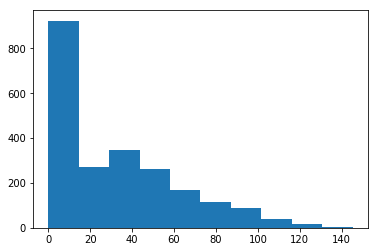

In [5]:
plt.hist( [x[1] for x  in training_set['f']] )

# PCA

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(training_set['nf'])

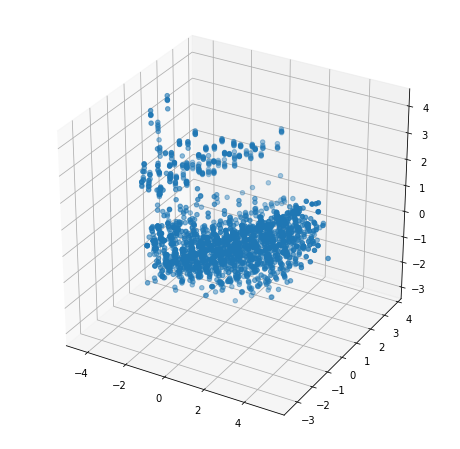

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( xs=[x[0] for x in reduced_features] , ys=[x[1] for x in reduced_features], zs=[x[2] for x in reduced_features] )


# plt.scatter( [ x[0] for x in reduced_features],[ x[1] for x in reduced_features] )

In [8]:
from sklearn.cluster import KMeans
classifier = KMeans(n_clusters=10)  

In [9]:
classifier.fit(training_set['nf'])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

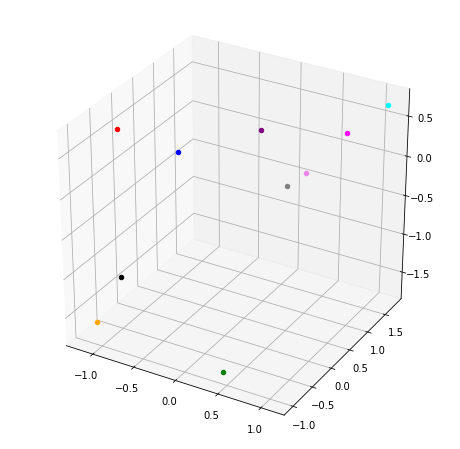

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for x in range(len(classifier.cluster_centers_)):
    ax.scatter( xs=classifier.cluster_centers_[x][0] , ys=classifier.cluster_centers_[x][1], zs=classifier.cluster_centers_[x][2], color=colors[x]  )


In [11]:
y = classifier.predict(training_set['nf'])

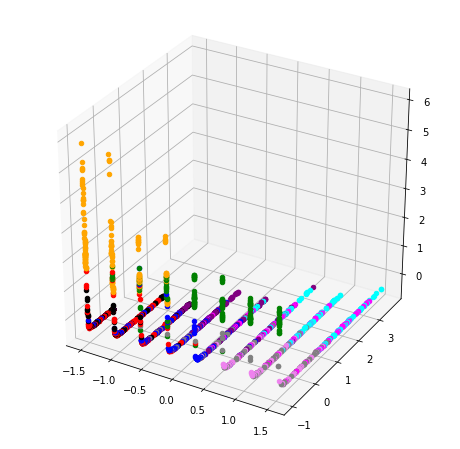

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for x in range(len(y)):
    ax.scatter( xs=training_set['nf'][x][0] , ys=training_set['nf'][x][1], zs=training_set['nf'][x][3], color=colors[y[x]]  )


# test



In [13]:
len(test_data['nf'])

708

In [14]:
y2= classifier.predict(  test_data['nf'])

In [15]:
y2

array([5, 0, 9, 9, 9, 9, 0, 0, 0, 5, 5, 5, 9, 9, 9, 9, 0, 5, 5, 5, 0, 0,
       9, 9, 9, 9, 0, 5, 5, 5, 0, 0, 9, 9, 9, 5, 5, 5, 5, 0, 0, 9, 9, 9,
       9, 0, 0, 0, 0, 9, 0, 0, 0, 9, 9, 9, 9, 0, 0, 0, 0, 5, 0, 0, 9, 9,
       9, 9, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 0, 5, 0, 1, 1, 1, 5, 5, 9, 9,
       9, 9, 0, 5, 0, 0, 0, 9, 5, 0, 0, 8, 0, 0, 5, 5, 9, 9, 5, 0, 0, 5,
       5, 8, 0, 0, 0, 9, 5, 0, 0, 5, 5, 8, 0, 0, 9, 9, 5, 5, 5, 5, 8, 0,
       0, 0, 9, 5, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 9, 9, 9, 0, 0, 8, 8, 8,
       0, 0, 0, 9, 5, 5, 5, 5, 5, 0, 0, 5, 9, 9, 0, 0, 0, 0, 1, 1, 1, 1,
       5, 5, 9, 9, 5, 0, 0, 0, 0, 1, 0, 0, 0, 8, 8, 8, 8, 5, 5, 1, 0, 0,
       0, 8, 5, 8, 8, 0, 0, 1, 9, 0, 0, 8, 5, 8, 8, 0, 1, 1, 5, 5, 5, 5,
       8, 8, 0, 0, 1, 9, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 8,
       8, 8, 8, 0, 0, 1, 0, 5, 5, 5, 5, 8, 8, 0, 5, 1, 0, 0, 0, 8, 1, 1,
       1, 1, 1, 5, 5, 1, 0, 0, 0, 0, 1, 1, 1, 0, 8, 8, 8, 8, 8, 2, 1, 1,
       1, 0, 8, 8, 8, 8, 8, 0, 1, 1, 1, 0, 8, 8, 8,

In [16]:
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')
# for x in range(len(y2)):
#     ax.scatter( xs=test_data[x][0] , ys=test_data[x][1], zs=test_data[x][3], color=colors[y2[x]]  )


In [17]:
np.array(np.unique( y2, return_counts=True )).T

array([[  0, 126],
       [  1,  85],
       [  2,   9],
       [  3, 140],
       [  4,  60],
       [  5,  69],
       [  6,  44],
       [  7,  43],
       [  8,  74],
       [  9,  58]])

In [18]:
np.array(np.unique( y, return_counts=True )).T

array([[  0, 284],
       [  1, 285],
       [  2, 148],
       [  3, 207],
       [  4, 279],
       [  5, 267],
       [  6, 171],
       [  7, 183],
       [  8, 233],
       [  9, 179]])

In [20]:
for x in range( len( training_set['nf'] ) ):
    print( "%d - %s " % ( y[x], training_set['sl' ][x] ) )

1 - [-342, -1185, -115] 
5 - [-1185, -115, 121] 
5 - [-115, 121, -424] 
5 - [121, -424, 113] 
5 - [-424, 113, -115] 
5 - [113, -115, 121] 
5 - [-115, 121, -425] 
5 - [121, -425, 113] 
5 - [-425, 113, -115] 
5 - [113, -115, 121] 
5 - [-115, 121, -425] 
5 - [121, -425, 113] 
0 - [-425, 113, -559] 
0 - [113, -559, -420] 
0 - [-559, -420, 113] 
0 - [-420, 113, -115] 
5 - [113, -115, 121] 
5 - [-115, 121, -425] 
5 - [121, -425, 113] 
0 - [-425, 113, -437] 
0 - [113, -437, 113] 
0 - [-437, 113, -435] 
5 - [113, -435, 113] 
0 - [-435, 113, -435] 
5 - [113, -435, 113] 
0 - [-435, 113, -373] 
5 - [113, -373, 499] 
9 - [-373, 499, -192] 
9 - [499, -192, 117] 
9 - [-192, 117, -132] 
9 - [117, -132, 111] 
9 - [-132, 111, -146] 
9 - [111, -146, 120] 
9 - [-146, 120, -223] 
9 - [120, -223, 103] 
9 - [-223, 103, -535] 
9 - [103, -535, 141] 
9 - [-535, 141, 97] 
0 - [141, 97, -426] 
0 - [97, -426, 113] 
0 - [-426, 113, 304] 
0 - [113, 304, -113] 
0 - [304, -113, -425] 
0 - [-113, -425, 113] 
1 - [-425

3 - [-120, -113, -115, 121, -743, 113, 113, 113, -115, 121] 
3 - [-113, -115, 121, -743, 113, 113, 113, -115, 121, -424] 
4 - [-115, 121, -743, 113, 113, 113, -115, 121, -424, 113] 
7 - [121, -743, 113, 113, 113, -115, 121, -424, 113, -373] 
4 - [-743, 113, 113, 113, -115, 121, -424, 113, -373, 499] 
4 - [113, 113, 113, -115, 121, -424, 113, -373, 499, -192] 
4 - [113, 113, -115, 121, -424, 113, -373, 499, -192, 117] 
4 - [113, -115, 121, -424, 113, -373, 499, -192, 117, -132] 
4 - [-115, 121, -424, 113, -373, 499, -192, 117, -132, 111] 
4 - [121, -424, 113, -373, 499, -192, 117, -132, 111, -146] 
4 - [-424, 113, -373, 499, -192, 117, -132, 111, -146, 120] 
4 - [113, -373, 499, -192, 117, -132, 111, -146, 120, -223] 
2 - [-373, 499, -192, 117, -132, 111, -146, 120, -223, 103] 
2 - [499, -192, 117, -132, 111, -146, 120, -223, 103, -535] 
2 - [-192, 117, -132, 111, -146, 120, -223, 103, -535, 141] 
2 - [117, -132, 111, -146, 120, -223, 103, -535, 141, 97] 
4 - [-132, 111, -146, 120, -223